# Dataset Generator

The Dataset Generator Notebook contains the data pre-processing. A cleansed and abstracted dataset is created from the domain lifecycle JSON files from the `all_json` folder. 

This process can be illustrated and explained schematically in the following process flow diagram.

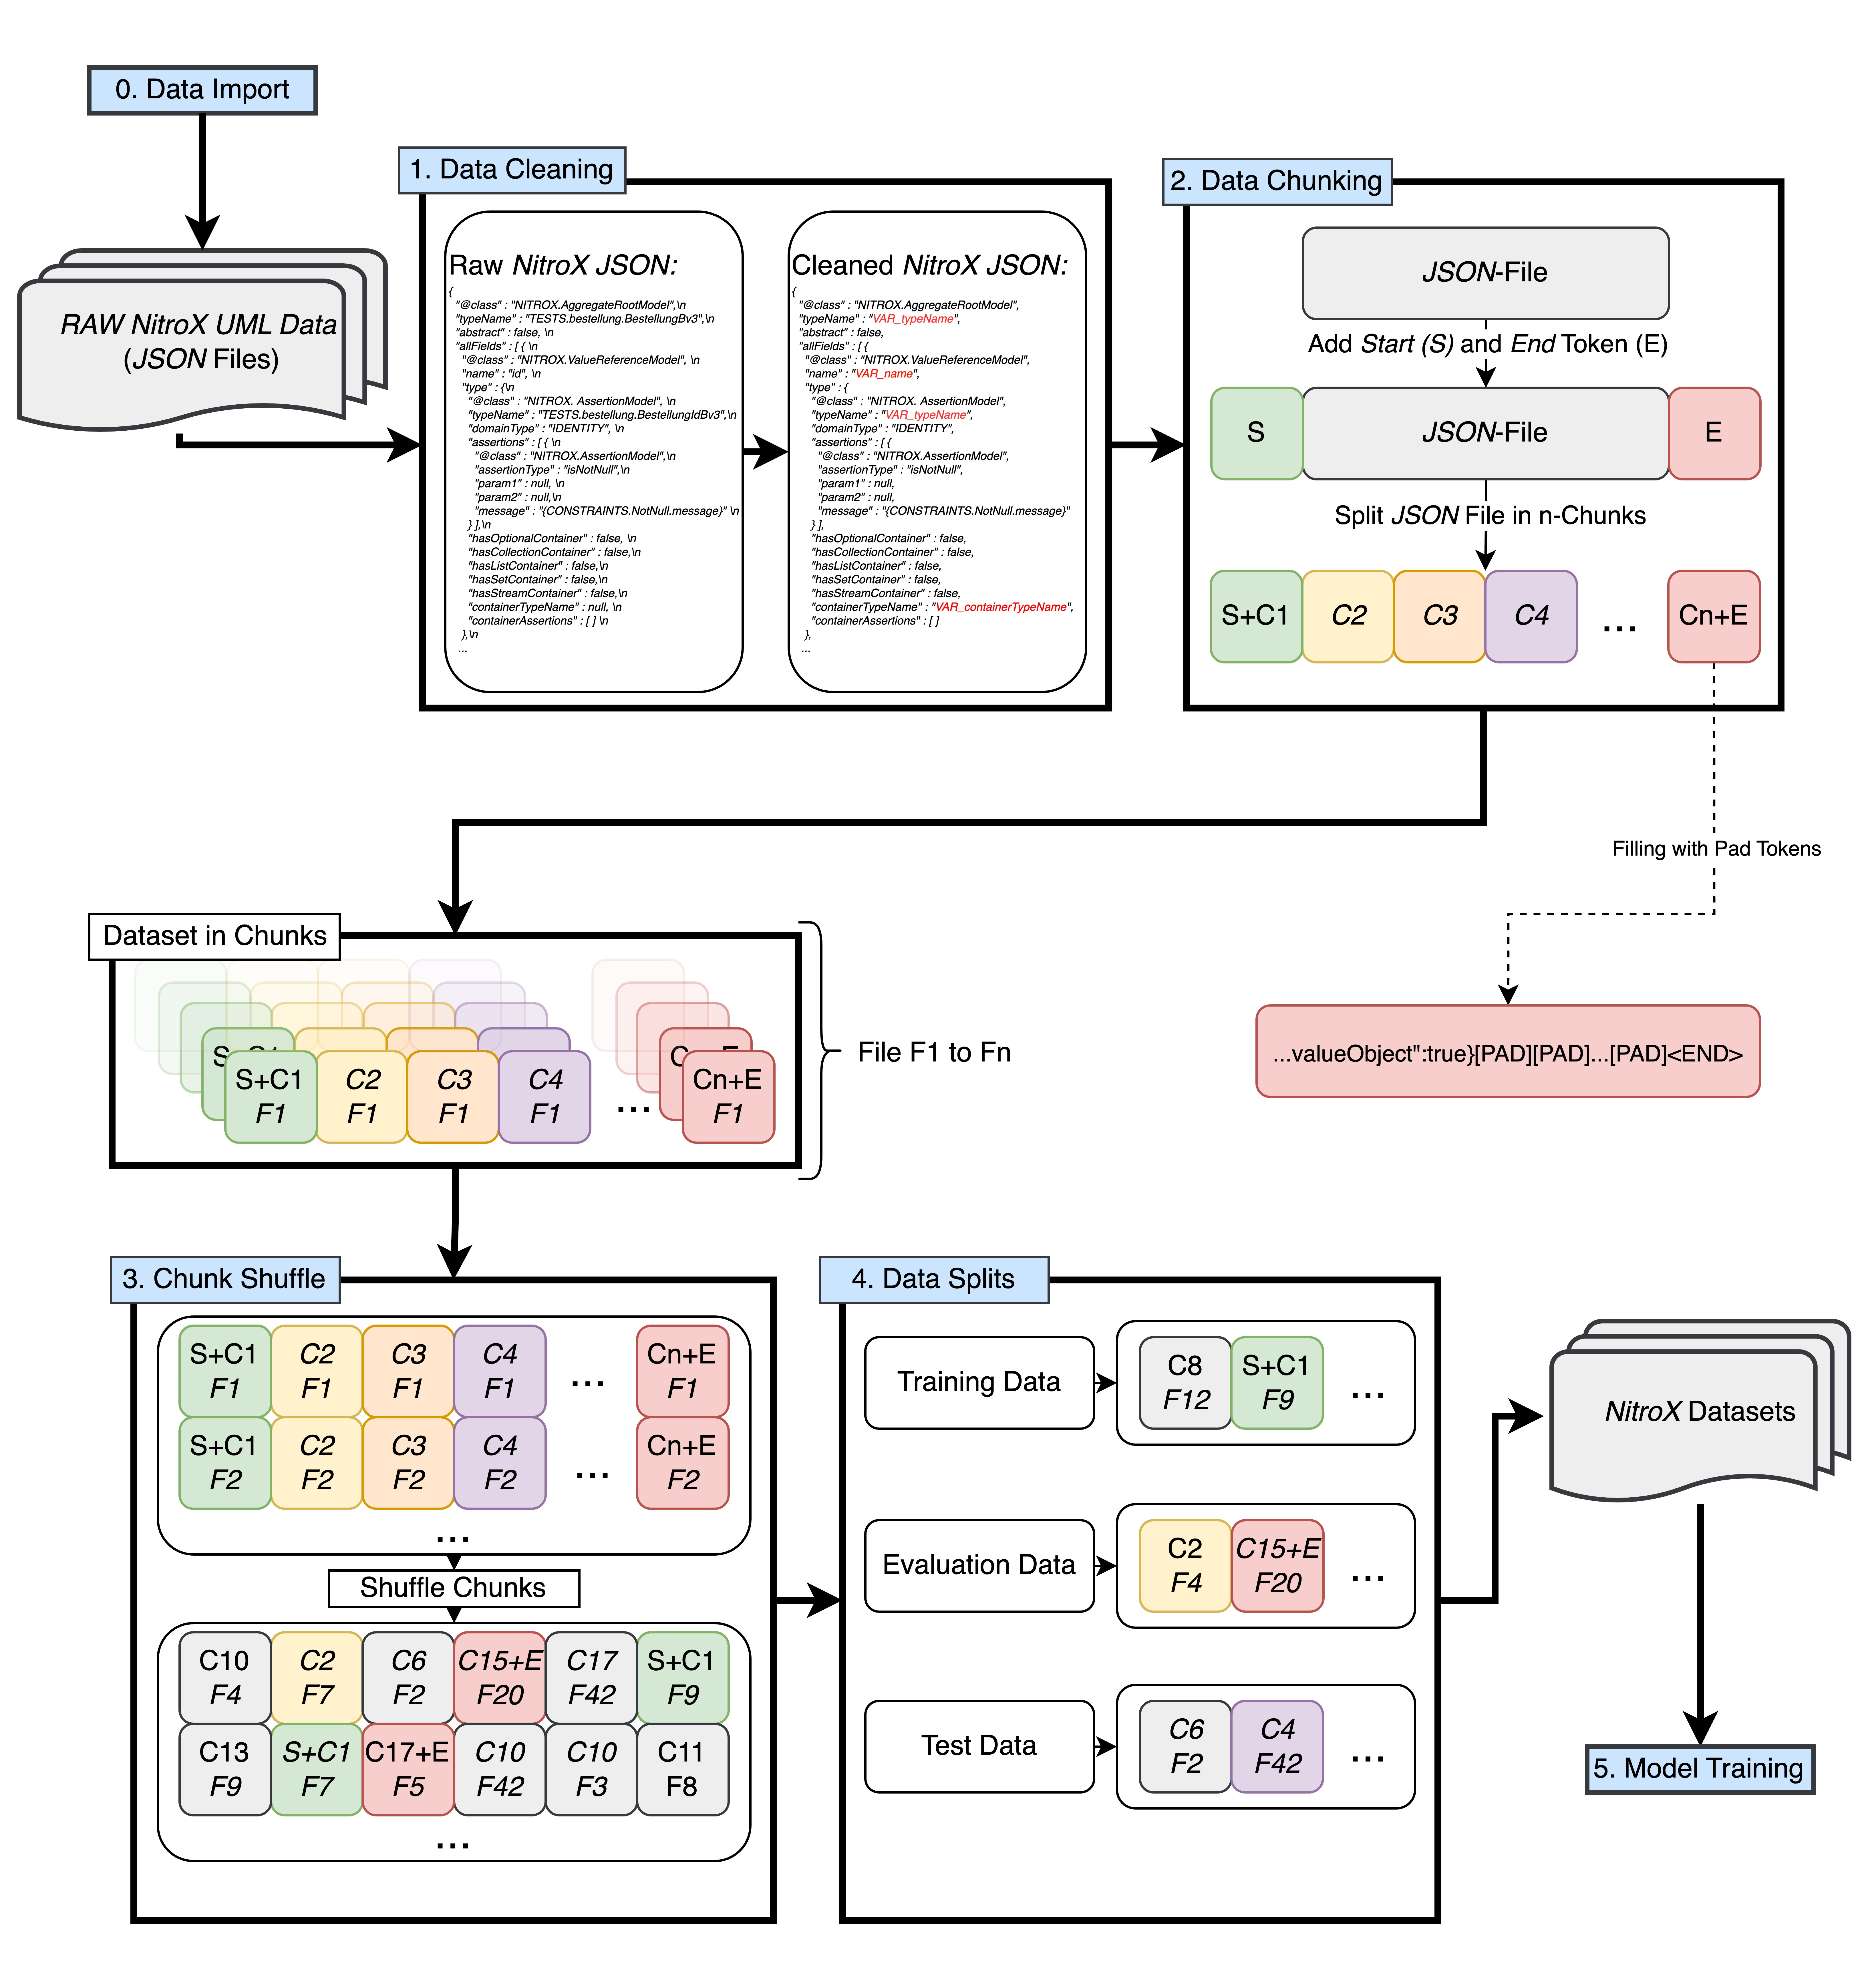

In [1]:
from IPython.display import Image, display
display(Image(filename='ColoredDataPreprocessingProcess.jpg', embed=True))

## Notebook-Setup

If not already installed, install the following packages and restart the kernel. 

Using a new python environment with python 3.10 is recommended. 

In [5]:
# importing the libraries
import pandas as pd
import os
import json
import datasets
import transformers


In [6]:
## define run name
# this name defines the dataset and model name and is used throughout all notebooks. Make sure to change it for each new run to a desired name
run_name = "NCG_RUN_1"

## define testing options
# set True for testing pipeline with smaller dataset
# If set to True, only a small subset of the dataset is used for testing purposes
nb_testing = True

# set numbers of rows from ~11k to take for testing
testing_size = 100

## set paths
# path to the json files folder
path = "./all_json/"
# define model for tokenizer
model_name = "codellama/CodeLlama-7b-hf"
# dataset export folder
export_folder = "./dataset/" + run_name + "/"

## set chunk size
# set max length for dataset
max_length = 2048
# max_length = 16000 # 16k tokens from paper -> https://arxiv.org/pdf/2308.12950.pdf


## set export options
save_dataset = True
save_test_train = True
save_df = True

## set random seed for dataset shuffling (See "3. Chunk Shuffling" in process flow diagram)
rand_seed = 42


## Data Pre-Processing Flow

### 0. Data Import

In [7]:
# import all json data from foler path as text
 

data = []
for file in os.listdir(path):
    with open(path+file, 'r') as f:
        data.append(f.read())

data[0]

'{\n  "@class" : "nitrox.dlc.mirror.model.ValueObjectModel",\n  "typeName" : "tests.shared.persistence.domain.valueobjectsPrimitive.ComplexVoPrimitive",\n  "abstract" : false,\n  "allFields" : [ {\n    "@class" : "nitrox.dlc.mirror.model.FieldModel",\n    "name" : "num",\n    "type" : {\n      "@class" : "nitrox.dlc.mirror.model.AssertedContainableTypeModel",\n      "typeName" : "java.lang.Long",\n      "domainType" : "NON_DOMAIN",\n      "assertions" : [ ],\n      "hasOptionalContainer" : false,\n      "hasCollectionContainer" : false,\n      "hasListContainer" : false,\n      "hasSetContainer" : false,\n      "hasStreamContainer" : false,\n      "containerTypeName" : null,\n      "containerAssertions" : [ ]\n    },\n    "accessLevel" : "PRIVATE",\n    "declaredByTypeName" : "tests.shared.persistence.domain.valueobjectsPrimitive.ComplexVoPrimitive",\n    "modifiable" : false,\n    "publicReadable" : true,\n    "publicWriteable" : false,\n    "static" : false\n  }, {\n    "@class" : "n

### 1. Data Cleaning

In [5]:
# add " " in front of every \n 
data = [i.replace("\n", " \n") for i in data]


In [7]:
def replace_key(json_data, key_value, replace_value):
    """Function to replace a key in a nested dictionary or list of dictionaries with a new value.
    """
    if isinstance(json_data, dict):
        for key, value in json_data.items():
            if key == key_value:
                json_data[key] = replace_value
            elif isinstance(value, (dict, list)):
                replace_key(value, key_value, replace_value)
    elif isinstance(json_data, list):
        for item in json_data:
            replace_key(item, key_value, replace_value)

In [8]:
def replace_key_if_not_null(json_data, key_value, replace_value):
    """Function to replace a key in a nested dictionary or list of dictionaries with a new value if the value is not None.
    """
    if isinstance(json_data, dict):
        for key, value in json_data.items():
            if key == key_value and value is not None:
                json_data[key] = replace_value
            elif isinstance(value, (dict, list)):
                replace_key_if_not_null(value, key_value, replace_value)
    elif isinstance(json_data, list):
        for item in json_data:
            replace_key_if_not_null(item, key_value, replace_value)

In [9]:
def insert_placeholder_for_var_values(data):
    """To make the Data generic, we replace all variable values with a placeholder
    input: data as string
    output: data as string
    """
    json_data = json.loads(data)
    ### replace lines
    ## replace all free text with "VAR_" 
    # typeName
    replace_key(json_data, "typeName", "VAR_typeName")
    # name
    replace_key(json_data, "name", "VAR_name")
    # domainType
    # replace_key(json_data, "domainType", "VAR_domainType_METAMODEL") # try out
    # containerTypeName 
    replace_key(json_data, "containerTypeName", "VAR_containerTypeName") 
    # declaredByTypeName
    replace_key(json_data, "declaredByTypeName", "VAR_declaredByTypeName")
    # publishedEventTypeNames
    replace_key(json_data, "publishedEventTypeNames", ["VAR_publishedEventTypeNames"])
    # listenedEventTypeName
    replace_key_if_not_null(json_data, "listenedEventTypeName", "VAR_listenedEventTypeName")
    # allInterfaceTypeNames
    replace_key(json_data, "allInterfaceTypeNames", ["VAR_allInterfaceTypeNames"])
    # referencedRepositoryTypeNames
    replace_key(json_data, "referencedRepositoryTypeNames", ["VAR_referencedRepositoryTypeNames"])
    # referencedDomainServiceTypeNames
    replace_key(json_data, "referencedDomainServiceTypeNames", ["VAR_referencedDomainServiceTypeNames"])
    # managedAggregateTypeName
    replace_key(json_data, "managedAggregateTypeName", "VAR_managedAggregateTypeName")
    # repositoryInterfaceTypeNames
    replace_key(json_data, "repositoryInterfaceTypeNames", ["VAR_repositoryInterfaceTypeNames"])
    # domainServiceInterfaceTypeNames
    replace_key(json_data, "domainServiceInterfaceTypeNames", ["VAR_domainServiceInterfaceTypeNames"])
    # inheritanceHierarchyTypeNames
    # replace_key(json_data, "inheritanceHierarchyTypeNames", ["VAR_inheritanceHierarchyTypeNames"])
    # applicationServiceInterfaceTypeNames
    replace_key(json_data, "applicationServiceInterfaceTypeNames", "VAR_applicationServiceInterfaceTypeNames")

    
    return json.dumps(json_data)
    

In [10]:
# clean data using the above function
data = [insert_placeholder_for_var_values(i) for i in data]

print(data[0])

{"@class": "nitrox.dlc.mirror.model.DomainServiceModel", "typeName": "VAR_typeName", "abstract": true, "allFields": [], "methods": [{"@class": "nitrox.dlc.mirror.model.MethodModel", "name": "VAR_name", "declaredByTypeName": "VAR_declaredByTypeName", "accessLevel": "PUBLIC", "parameters": [{"@class": "nitrox.dlc.mirror.model.ParamModel", "name": "VAR_name", "type": {"@class": "nitrox.dlc.mirror.model.AssertedContainableTypeModel", "typeName": "VAR_typeName", "domainType": "AGGREGATE_ROOT", "assertions": [], "hasOptionalContainer": false, "hasCollectionContainer": false, "hasListContainer": false, "hasSetContainer": false, "hasStreamContainer": false, "containerTypeName": "VAR_containerTypeName", "containerAssertions": []}}], "returnType": {"@class": "nitrox.dlc.mirror.model.AssertedContainableTypeModel", "typeName": "VAR_typeName", "domainType": "AGGREGATE_ROOT", "assertions": [], "hasOptionalContainer": false, "hasCollectionContainer": false, "hasListContainer": false, "hasSetContainer

In [11]:
# create df from data
df = pd.DataFrame(data, columns=["data"])

df.head()

,data
0,"{""@class"": ""nitrox.dlc.mirror.model.DomainServ..."
1,"{""@class"": ""nitrox.dlc.mirror.model.EnumModel""..."
2,"{""@class"": ""nitrox.dlc.mirror.model.EnumModel""..."
3,"{""@class"": ""nitrox.dlc.mirror.model.Repository..."
4,"{""@class"": ""nitrox.dlc.mirror.model.DomainServ..."


### 2. Data Chunking

#### Add Start and End Tokens

In [12]:
# Add special character as Start of the document
df["data"] = "<START>" + df["data"] + "<END>"

df.head()

,data
0,"<START>{""@class"": ""nitrox.dlc.mirror.model.Dom..."
1,"<START>{""@class"": ""nitrox.dlc.mirror.model.Enu..."
2,"<START>{""@class"": ""nitrox.dlc.mirror.model.Enu..."
3,"<START>{""@class"": ""nitrox.dlc.mirror.model.Rep..."
4,"<START>{""@class"": ""nitrox.dlc.mirror.model.Dom..."


In [13]:
# format df to dataset object
dataset = datasets.Dataset.from_pandas(df)

In [14]:
dataset

Dataset({
    features: ['data'],
    num_rows: 1022
})

#### Chunking

In [15]:
# initialize tokenizer and add pad token
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [16]:
# tokenize dataset -> no truncation to get full length
tokenized_dataset = dataset.map(lambda x: tokenizer(x['data'], truncation=False), batched=True)

Map:   0%|          | 0/1022 [00:00<?, ? examples/s]

In [17]:
# drop data column from dataset to save memory
# in data column is the original text
tokenized_dataset = tokenized_dataset.remove_columns('data')

In [18]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1022
})

In [19]:
print(len(tokenized_dataset[0]["input_ids"]))
print(len(tokenized_dataset))

3317
1022


##### Generate rows with max_lenght

In [20]:
# get pad token
pad_token = tokenizer.pad_token_id

In [21]:
# split each row in multiple rows with length max_length
split_rows = []
for row in tokenized_dataset:

    # Retrieve the input_ids and attention_mask from the row
    input_ids = row['input_ids']
    attention_mask = row['attention_mask']

    # Calculate the number of splits needed based on the length of input_ids
    num_splits = len(input_ids) // max_length + (1 if len(input_ids) % max_length != 0 else 0)

    # Split input_ids and attention_mask into chunks of length max_length
    for i in range(num_splits):
        start_idx = i * max_length
        end_idx = min((i + 1) * max_length, len(input_ids))
        split_input_ids = input_ids[start_idx:end_idx]
        split_attention_mask = attention_mask[start_idx:end_idx]

        # Append the split rows to the split_rows list
        split_rows.append({'input_ids': split_input_ids, 'attention_mask': split_attention_mask})


In [22]:
# Convert the split_rows list into a DataFrame
tokenized_dataset = pd.DataFrame(split_rows)

In [23]:
# drop attention_mask column -> this will be recalculated later in the second tokenization step
tokenized_dataset = tokenized_dataset.drop(columns=['attention_mask'])

In [24]:
# we have to decode the chunks to get the original text back to encode it properly again
# this ensures that the dataset is in the correct format for the model training

# decode input_ids back to text
tokenized_dataset['input_ids'] = tokenized_dataset['input_ids'].apply(lambda x: tokenizer.decode(x)) 

In [25]:
# shuffle the rows to ensure that the chunks are not ordered
tokenized_dataset = tokenized_dataset.sample(frac=1, random_state=rand_seed).reset_index(drop=True)

In [26]:
# in case we want to test the pipeline with a smaller number of rows we take only the first x rows
if nb_testing:
    tokenized_dataset = tokenized_dataset.head(testing_size)

In [27]:
# create dataset from df
tokenized_dataset = datasets.Dataset.from_pandas(tokenized_dataset)

In [28]:
# encode dataset again
tokenized_dataset = tokenized_dataset.map(lambda x: tokenizer(x['input_ids'], truncation=True, max_length=max_length), batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [29]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 100
})

In [30]:
# print length to test if the chunks are correct
len(tokenized_dataset["input_ids"][0])

512

### 3. Chunk Shuffle and 4. Data Splits 

In [31]:
# make a test train split
dataset_test_split = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True, seed=rand_seed)


# split the dataset_test_split into test and train
train_dataset = dataset_test_split['train']
test_dataset = dataset_test_split['test']

In [32]:
# make a eval train split from the train dataset
dataset_eval_split = train_dataset.train_test_split(test_size=0.2, shuffle=True, seed=rand_seed)

# split the dataset_eval_split into eval and train
eval_dataset = dataset_eval_split['test']
train_dataset = dataset_eval_split['train']


In [33]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 64
})

## Dataset Export

In [34]:
# save dataset to disk if save_dataset = True
if save_dataset:
    tokenized_dataset.save_to_disk(export_folder + "full_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [35]:
# save train and test dataset split to disk if save_test_train = True
if save_test_train:
    train_dataset.save_to_disk(export_folder + "train_dataset")
    test_dataset.save_to_disk(export_folder + "test_dataset")
    eval_dataset.save_to_disk(export_folder + "eval_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/16 [00:00<?, ? examples/s]

In [36]:
if save_df:
    df.to_csv(export_folder + "raw_data_df.csv", index=False)